In [1]:
import brnn_model
import sys  
import import_folders
%matplotlib inline
import pickle_lib as pkl
import utilities_lib as ul
from graph_lib import gl
import numpy as np
## Load the data once !!
import mpmath as mpm
# Import specific model libraries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, ExpSineSquared
from sklearn import preprocessing
from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib import cm as cm


plt.close("all") # Close all previous Windows

In [2]:
### Generation of the easy signal

def mean_function(tgrid, f1 = 1, f2 = 5, a1 = 0.4, a2 = 0.2, 
                      phi2 = 2*np.pi/7, m = 0.1 ):
    # This function outputs the function that we want to estimate.
    """
    m = 0.1   # Slope of the linear trend
    f1 = 1      # Frquency of first sinusoid
    f2 = 5      # Frequency of second sinusoid
    a1 = 0.4;   # Amplitud of the first sinuoid
    a2 = 0.2    # Amplitud of the second sinusoid
    phi2 = 2*np.pi/7    # Phase shifting of the second sinuoid
    
    """
    linear_trend = m*tgrid
    sin1 = a1* np.cos(2*np.pi*f1*tgrid)
    sin2 = a2*np.cos(2*np.pi*f2*tgrid + phi2)
    
    X = linear_trend + sin1 + sin2
    X = X.reshape(X.size,1)

    return X

################  Covariance Matrix "K" #################################
 #We compute the distances among each pair of points in X_grid

def get_Kernel (tgrid, kernel_type = "1", l = 0.001, sigma_noise = 1):
    if (kernel_type == "1"):
        # Hyperparameters
        #l = 0.0001  # 
        # k = 1;   #
        distances = spatial.distance.cdist(tgrid,tgrid,'euclidean')
        K = np.exp(-np.power(distances,2)/(2*l))
        K = K/ K[0,0] 
        K = K* sigma_noise
        
    elif (kernel_type == "2"):
        """
        This is the most noisy possible kernel since each sample has its own noise
        that is independent from the rest. Knowing the previous noise value
        gives no information about this one.
        
        The Marginal error is the same, but if the samples are uncorrelated then the signal
        if just completely noisy, no smoothness.
        
        """
        # Hyperparameters
        # sigma_noise = 1
        K = np.eye(N) * sigma_noise
    
    return K



/home/montoya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


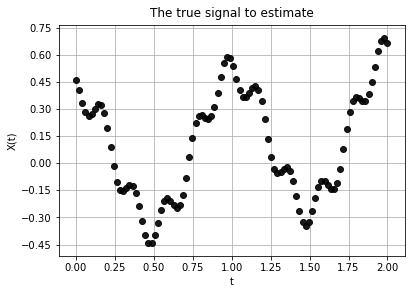

['Determinant by mpm:', mpf('7.3128891337494991e-178')]
['Determinant by numpy:', 7.3129219013338985e-178]


In [3]:

#######################################################################
############### Generate the signal ###################################
#######################################################################

t0 = 0          # Initial time         
tf = 2        # Final time
delta_t = 0.02   # Period of sampling

# Create the t- values
tgrid = np.linspace(t0,tf, int(float(tf-t0)/delta_t))
tgrid = tgrid.reshape(tgrid.size,1)
N = tgrid.size

# Create the signal 
X = mean_function(tgrid, f1 = 1, f2 = 5, a1 = 0.4, a2 = 0.1, 
                      phi2 = 2*np.pi/7, m = 0.1 )

plot_mean_signal = 1
if (plot_mean_signal):
    ## Plot the orginal function
    gl.scatter(tgrid,X, lw = 1, alpha = 0.9, color = "k", nf = 1, 
               labels = ["The true signal to estimate", "t", "X(t)" ])
    gl.plot(tgrid,X, lw = 2, color = "k", ls = "--",  legend = ["True signal"])


###########################################################################
############### Generate the structural noise #############################
###########################################################################

""" Now we generate the stocastic process that we add to X(t), 
    generating noisy signal Y(t) = X(t) + e(t)
    
    Where we will assume e(t) is Gaussian with mean 0 e(t) \sim N(0,\sigma_t)
    So we have a Gaussian process, since each set of samples forms a jointly
    gaussian distribution. The relation between the noises will be given by the
    covariance matrix C. This will tell how big the noises are and how they relate
    to each other.
    
    We will use a basic kernel for now

"""

K = get_Kernel(tgrid, kernel_type = "1", l = 0.01, sigma_noise = 0.5)

############# Compute properties of the Kernel ########################
N_det = 30 # Number of samples to compute the determinant from 

det_K2 = mpm.det(K[:N_det,:N_det]+ 1e-10*np.eye(N_det))
det_K = np.linalg.det(K[:N_det,:N_det]+ 1e-10*np.eye(N_det))   # Determinant ! "Noisiness of the kernel"
                           # The bigger the determinant, the more random ? 
print (["Determinant by mpm:", det_K2])
print (["Determinant by numpy:", det_K])
# Choleski factorization ! To sample from the Multivatiate Gaussian.
# To ensure that it is positive definite we add a small noise to the diagonal
L = np.linalg.cholesky(K+1e-10*np.eye(N))

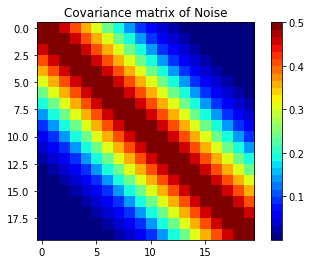

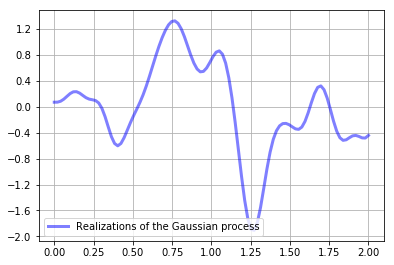

In [4]:
plot_stochastic_process = 1
if (plot_stochastic_process):
    
    ## Plot the covariance matrix ! 
    # Show the Nshow first samples
    
    Nshow = 20
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(K[0:Nshow,0:Nshow], interpolation="nearest", cmap=cmap)
    
#    ax1.grid(True)
    plt.title('Covariance matrix of Noise')
#    labels=[str(x) for x in range(Nshow )]
#    ax1.set_xticklabels(labels,fontsize=20)
#    ax1.set_yticklabels(labels,fontsize=20)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax)
    plt.show()
    
    
    ## Plot realizations of the Gaussian process
    Nrealizations = 10
    
    flag = 1;
    legend = ["Realizations of the Gaussian process"]
    labels = ["Gaussian Process","t", "e(t)"]
    
    for i in range(Nrealizations):
        f_prime = np.random.randn(N,1)
        error = L.dot(f_prime) 
        gl.plot(tgrid,error, lw = 3, color = "b", ls = "-", alpha = 0.5, 
                nf = flag, legend = legend)
#        gl.scatter(tgrid,f_prime, lw = 1, alpha = 0.3, color = "b")
        
        if (flag == 1):
            flag = 0
            legend = []
    
    #Variance of each prediction
    v = np.diagonal(K)
    gl.fill_between(tgrid, -2*np.sqrt(v), 2*np.sqrt(v), lw = 3, alpha = 0.5, color = "yellow", legend = ["95% confidence interval"]);
    gl.plot(tgrid,  2*np.sqrt(v), lw= 1, alpha =  0.5, color = "yellow", legend = ["95% confidence interval"]);
    gl.plot(tgrid,  2*np.sqrt(v), lw= 1, alpha =  0.5, color = "yellow");

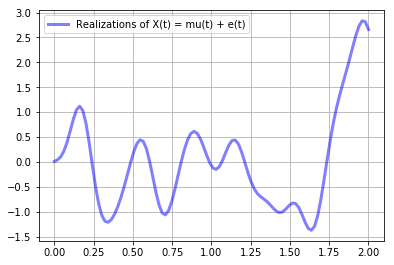

In [5]:
###########################################################################
############### Getting the combined noisy signal #########################
###########################################################################
plot_realizations_signal = 1
if (plot_realizations_signal):
    flag = 1;
    legend = ["Realizations of X(t) = mu(t) + e(t)"]
    for i in range(10):
        f_prime = np.random.randn(N,1)
        error = L.dot(f_prime)
        f =  X + error
                
    #    gl.scatter(tgrid,f, lw = 1, alpha = 0.3, color = "b")
        gl.plot(tgrid,f, lw = 3, color = "b", ls = "-", alpha = 0.5, nf = flag, legend = legend)
        if (flag == 1):
            flag = 0
            legend = []
    
    
    #Variance of each prediction
    v = np.diagonal(K)
    gl.fill_between(tgrid, X-2*np.sqrt(v), X+ 2*np.sqrt(v), lw = 3, alpha = 0.5, color = "yellow", legend = ["95% confidence interval"]);
    gl.plot(tgrid, X+ 2*np.sqrt(v), lw= 1, alpha =  0.5, color = "yellow", legend = ["95% confidence interval"]);
    gl.plot(tgrid, X- 2*np.sqrt(v), lw= 1, alpha =  0.5, color = "yellow");
    

/home/montoya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


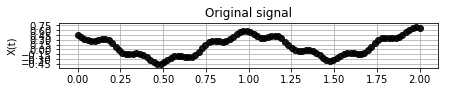

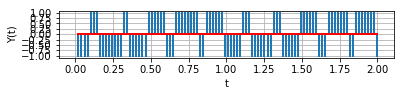

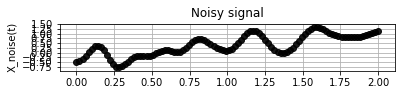

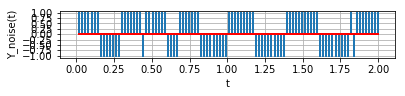

In [6]:
###########################################################################
############### Getting a noisy signal and label it #########################
###########################################################################

# Generate noisy signal:
f_prime = np.random.randn(N,1)
error = L.dot(f_prime)
X_noisy = X + error

# Label the original and new signal
Y = np.sign(np.diff(X,n=1,axis = 0))
Y_noisy = np.sign(np.diff(X_noisy,n=1,axis = 0))

gl.set_subplots(4,1)
# Plot the original signal and its labelling ! 
ax1 = gl.scatter(tgrid,X, lw = 1, alpha = 0.9, color = "k", nf = 1,
                 labels = ["Original signal","","X(t)"])
gl.plot(tgrid,X, lw = 2, color = "k", ls = "--")
gl.stem(tgrid[1:,0], Y, sharex = ax1, nf = 1, labels = ["", "t","Y(t)"])

# Plot noisy part
gl.scatter(tgrid,X_noisy, lw = 1, alpha = 0.9, color = "k", nf = 1,
                 labels = ["Noisy signal","","X_noise(t)"])
gl.plot(tgrid,X_noisy, lw = 2, color = "k", ls = "--")
gl.stem(tgrid[1:,0], Y_noisy, sharex = ax1, nf = 1, labels = ["", "t","Y_noise(t)"])

In [8]:
###########################################################################
############### GENERATE THE DATA TO SAVE TO DISK !! #########################
###########################################################################

Nchains = 300           # Number of chains to generate !
Lenght_chains = 50      # Length of the correlated chains

Lenght_chains = Lenght_chains +1 # Since the first sample is not useful because we cannot compute its increase.
# Compute the kernel and the realizations
N = Lenght_chains
X_list = []
Y_list = []

for i in range(Nchains):
    # Generate the chain
    t0 = 0          # Initial time         
    delta_t = 0.02   # Period of sampling
    tf = t0 + Lenght_chains*delta_t         # Final time
    # Create the t- values
    tgrid = np.linspace(t0,tf, Lenght_chains)
    tgrid = tgrid.reshape(tgrid.size,1)
    N = tgrid.size
    
    # Create the signal 
    X = mean_function(tgrid, f1 = 1, f2 = 5, a1 = 0.4, a2 = 0.1, 
                          phi2 = 2*np.pi/7, m = 0.1 )

    # Generate the noise
    K = get_Kernel(tgrid, kernel_type = "1", l = 0.01, sigma_noise = 1)
    L = np.linalg.cholesky(K+1e-10*np.eye(N))
    f_prime = np.random.randn(N,1)
    error = L.dot(f_prime)
    
    X_noisy = X + error
    # Label the original and new signal
    Y = np.sign(np.diff(X,n=1,axis = 0))
    Y_noisy = np.sign(np.diff(X_noisy,n=1,axis = 0))

    X_list.append(X_noisy[1:,[0]])
    Y_list.append(Y_noisy[1:,[0]])


########## Using Pickle ###############

Ndivisions = 10;
folder_data = "./artificial_data/"
ul.create_folder_if_needed(folder_data)
    

# Cannot use it due to incompatibilities Python 2 and 3
pkl.store_pickle(folder_data +"X_values.pkl",X_list,Ndivisions)
pkl.store_pickle(folder_data +"Y_values.pkl",Y_list,Ndivisions)

## Test to load the files back 
X_list2 = pkl.load_pickle(folder_data +"X_values.pkl",Ndivisions)
Y_list2 = pkl.load_pickle(folder_data +"Y_values.pkl",Ndivisions)

Creating file: ./artificial_data/X_values0.pkl
Creating file: ./artificial_data/X_values1.pkl
Creating file: ./artificial_data/X_values2.pkl
Creating file: ./artificial_data/X_values3.pkl
Creating file: ./artificial_data/X_values4.pkl
Creating file: ./artificial_data/X_values5.pkl
Creating file: ./artificial_data/X_values6.pkl
Creating file: ./artificial_data/X_values7.pkl
Creating file: ./artificial_data/X_values8.pkl
Creating file: ./artificial_data/X_values9.pkl
Creating file: ./artificial_data/Y_values0.pkl
Creating file: ./artificial_data/Y_values1.pkl
Creating file: ./artificial_data/Y_values2.pkl
Creating file: ./artificial_data/Y_values3.pkl
Creating file: ./artificial_data/Y_values4.pkl
Creating file: ./artificial_data/Y_values5.pkl
Creating file: ./artificial_data/Y_values6.pkl
Creating file: ./artificial_data/Y_values7.pkl
Creating file: ./artificial_data/Y_values8.pkl
Creating file: ./artificial_data/Y_values9.pkl
